In [37]:
# Analyze games and save evaluation for each move

In [384]:
import chess #https://github.com/niklasf/python-chess
from stockfish import Stockfish

#We'll create an intentionally worse stockfish engine to estimate complexity of positions
stockfish_good=Stockfish("C:/Users/aober/Documents/Data_Science_Studium/4Semester/BigData/stockfish/stockfish-windows-x86-64-avx2.exe")
stockfish_good.set_depth(20)#How deep the AI looks
stockfish_good.set_skill_level(20)#Highest rank stockfish
import chess.pgn
import pandas as pd
pd.options.display.max_columns=999
import datetime
import tqdm
import zipfile

In [286]:
file_name = "apendra_games"

In [287]:
games=pd.read_csv(f"../../testData/{file_name}.csv")

In [240]:
def safe_convert_to_int(value):
    try:
        return int(value)
    except ValueError:
        return None  # or you can use np.nan or a placeholder like -1

In [288]:
games['moves']=games['moves'].apply(lambda x: eval(x))
games['headers']=games['headers'].apply(lambda x: eval(x))#to dict

# Running Stored Game


In [289]:
#Standard point values for different pieces. Lowercase is white piece and uppercase is black
piece_scores={
    "p": 1,
    "P": -1,
    "r": 5,
    "R": -5,
    "n": 3,
    "N": -3,
    "b": 3,
    "B": -3,
    "q": 9,
    "Q": -9
}

All we have to do is iterate through moves. For [chessnit.com](http://www.chessnit.com) I was looking at specific positions so I simply chose a random number to evaluate in each game.

In [368]:
def get_accuracy(evaluation_change):
    if (evaluation_change <= 25 and evaluation_change >= -25):
        return 100
    elif (evaluation_change > 25 and evaluation_change <= 50) or (evaluation_change < -25 and evaluation_change >= -50):
        return 75
    elif (evaluation_change > 50 and evaluation_change <= 75) or (evaluation_change < -50 and evaluation_change >= -75):
        return 50
    elif (evaluation_change > 75 and evaluation_change <= 100) or (evaluation_change < -75 and evaluation_change >= -100):
        return 25
    else:
        return 0


In [369]:
import random

#Used by chessnit.com
def build_stored_game_analysis(game, move_number, prev_evaluation):
    row={}
    row['move_number']=move_number
    row['taken']=[]
    board=chess.Board()
    for san in game['moves'][:move_number]:
        parsed_san=board.parse_san(san)
        taken=board.piece_at(parsed_san.to_square)
        if taken:
            row['taken'].append(taken.__str__())
        move=board.push_san(san)
    row['invalid']=bool(board.promoted) or bool(board.outcome())
    stockfish_good.set_fen_position(board.fen())
    evaluation=stockfish_good.get_evaluation()
    row['evaluation']=evaluation['value']
    row['evaluation_change']=evaluation['value']-prev_evaluation
    row['accuracy'] = get_accuracy(row['evaluation_change'])
    
    
    row['taken_score']=sum([piece_scores.get(p) for p in row['taken']])*100
    row['fen']=board.fen()
    row['url']=game['headers'].get("_tag_roster", {}).get("Site", "")+f"#{move_number}"
    try:
        row['last_move']=san
    except:
        print(game)
        row['invalid']=True
    return row, evaluation['value']


In [294]:

import pandas as pd
import tqdm

def analyze_games(games, n, max_move_number):
    all_game_analysis = []
    
    # Iterate over the first n games in the DataFrame
    prev_evaluation  = 0
    for i in tqdm.tqdm(range(min(n, len(games)))):
        game = games.iloc[i]
        game_analysis = []
        
        # Analyze each game up to the specified move number
        for move_number in range(1, max_move_number + 1):
            analysis_result, current_evaluation = build_stored_game_analysis(game, move_number,prev_evaluation)
            game_analysis.append(analysis_result)
            prev_evaluation = current_evaluation
        # Store the analysis results for each game
        all_game_analysis.append(pd.DataFrame(game_analysis).set_index("move_number"))
    
    return all_game_analysis


In [385]:

# Define the number of games and the maximum move number you want to analyze
n_games = 10  # For example, analyze the first 10 games
max_move_number = 10

# Assuming 'games' is your DataFrame containing the games
games_analysis = analyze_games(games, n_games, max_move_number)

# Now, games_analysis is a list of DataFrames, each containing the analysis of one game


100%|██████████| 10/10 [01:52<00:00, 11.30s/it]


In [387]:
games_analysis[1]

,taken,invalid,evaluation,evaluation_change,accuracy,taken_score,fen,url,last_move
move_number,,,,,,,,,
1,[],False,18,-11,100,0,rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR ...,https://lichess.org/W4qIfyPj#1,c2c4
2,[],False,24,6,100,0,rnbqkbnr/pppp1ppp/8/4p3/2P5/8/PP1PPPPP/RNBQKBN...,https://lichess.org/W4qIfyPj#2,e7e5
3,[],False,-202,-226,0,0,rnbqkbnr/pppp1ppp/8/2P1p3/8/8/PP1PPPPP/RNBQKBN...,https://lichess.org/W4qIfyPj#3,c4c5
4,[P],False,-197,5,100,-100,rnbqk1nr/pppp1ppp/8/2b1p3/8/8/PP1PPPPP/RNBQKBN...,https://lichess.org/W4qIfyPj#4,f8c5
5,[P],False,-227,-30,75,-100,rnbqk1nr/pppp1ppp/8/2b1p3/8/6P1/PP1PPP1P/RNBQK...,https://lichess.org/W4qIfyPj#5,g2g3
6,[P],False,-235,-8,100,-100,rnbqk2r/pppp1ppp/5n2/2b1p3/8/6P1/PP1PPP1P/RNBQ...,https://lichess.org/W4qIfyPj#6,g8f6
7,[P],False,-233,2,100,-100,rnbqk2r/pppp1ppp/5n2/2b1p3/8/6P1/PP1PPPBP/RNBQ...,https://lichess.org/W4qIfyPj#7,f1g2
8,[P],False,-223,10,100,-100,rnbqk2r/ppp2ppp/5n2/2bpp3/8/6P1/PP1PPPBP/RNBQK...,https://lichess.org/W4qIfyPj#8,d7d5
9,[P],False,-261,-38,75,-100,rnbqk2r/ppp2ppp/5n2/2bpp3/8/1P4P1/P2PPPBP/RNBQ...,https://lichess.org/W4qIfyPj#9,b2b3


# Aggregations and visualizations

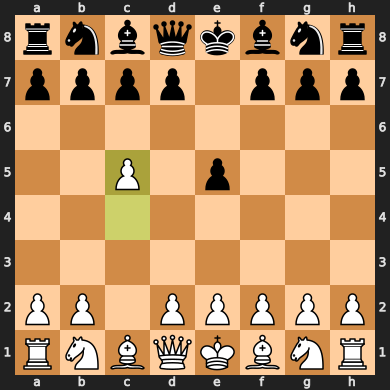

In [394]:
#Visualizazion of given game
game=games.iloc[1]

move_number=3
row={}
row['taken']=[]
board=chess.Board()
for san in game['moves'][:move_number]:
    parsed_san=board.parse_san(san)#move by the san "Standard Algebraic Notation"
    taken=board.piece_at(parsed_san.to_square)
    if taken:
        row['taken'].append(taken.__str__())
    move=board.push_san(san)
board

In [365]:
games.columns.tolist()

['headers',
 'moves',
 'lichess_id',
 'white_elo',
 'black_elo',
 'ECO',
 'opening_name',
 'event',
 'player_color',
 'score']

In [389]:
game_index = 1
df = pd.DataFrame(games_analysis[game_index]['evaluation_change'], columns=['evaluation_change'])
df2 = pd.DataFrame(games_analysis[game_index]['evaluation'], columns=['evaluation'])

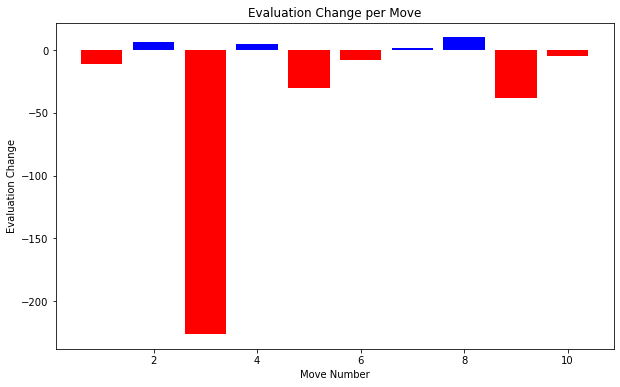

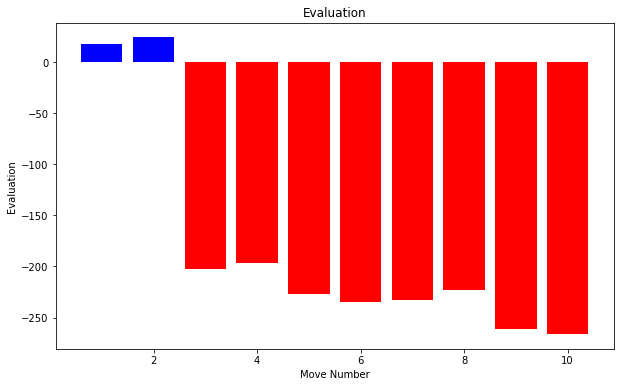

The largest change was -226 on move 3.
https://lichess.org/W4qIfyPj#3


In [390]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming games_analysis[0]['evaluation_change'] is a list or similar structure
df['move_number'] = range(1, len(df) + 1)
df2['move_number'] = range(1, len(df) + 1)

plt.figure(figsize=(10, 6))
plt.bar(df['move_number'], df['evaluation_change'], color=df['evaluation_change'].apply(lambda x: 'blue' if x >= 0 else 'red'))
plt.xlabel('Move Number')
plt.ylabel('Evaluation Change')
plt.title('Evaluation Change per Move')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(df2['move_number'], df2['evaluation'], color=df2['evaluation'].apply(lambda x: 'blue' if x >= 0 else 'red'))
plt.xlabel('Move Number')
plt.ylabel('Evaluation')
plt.title('Evaluation')
plt.show()

biggest_change = 0
move = 1

for index, change in enumerate(df['evaluation_change'], start=1):
    # Check if the absolute value of the change is larger than the biggest_change
    if abs(change) > abs(biggest_change):
        biggest_change = change
        move = index

print(f"The largest change was {biggest_change} on move {move}.")
print(games_analysis[game_index]['url'][move])
        

In [360]:
games[0:58][games['player_color'] == "Black"]

C:\Users\aober\AppData\Local\Temp\ipykernel_1928\3509513166.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  games[0:58][games['player_color'] == "Black"]


,headers,moves,lichess_id,white_elo,black_elo,ECO,opening_name,event,player_color,score
0,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c...",https://lichess.org/R5xvWQmB,1393.0,1490.0,C68,"Ruy Lopez: Exchange Variation, Keres Variation",Rated Bullet game,Black,0.0
1,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[c2c4, e7e5, c4c5, f8c5, g2g3, g8f6, f1g2, d7d...",https://lichess.org/W4qIfyPj,1468.0,1485.0,A20,English Opening: King's English Variation,Rated Bullet game,Black,1.0
3,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...",https://lichess.org/vBCaaIq2,1549.0,1484.0,C52,"Italian Game: Evans Gambit, Pierce Defense",Rated Bullet game,Black,1.0
6,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d4, f7f5, c1f4, g8f6, g1f3, e7e6, e2e3, b7b...",https://lichess.org/zGzfZ9ew,1474.0,1464.0,A80,Dutch Defense,Rated Bullet game,Black,1.0
9,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, c2c3, g8f...",https://lichess.org/KEkOpdsl,1492.0,1483.0,C54,"Italian Game: Giuoco Piano, Greco's Attack",Rated Bullet game,Black,0.0
10,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d4, f7f5, c1f4, g8f6, e2e3, e7e6, g1f3, f8e...",https://lichess.org/nItMHMv2,1493.0,1489.0,A80,Dutch Defense,Rated Bullet game,Black,0.0
12,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, f1c4, b8c6, d2d3, f8c5, c2c3, g8f...",https://lichess.org/t6kU1MF8,1469.0,1488.0,C23,Bishop's Opening,Rated Bullet game,Black,0.0
14,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d4, f7f5, c2c4, g8f6, b1c3, e7e6, e2e3, f8b...",https://lichess.org/BcoQdj3B,1397.0,1478.0,A85,Dutch Defense: Queen's Knight Variation,Rated Bullet game,Black,1.0
17,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[d2d3, e7e5, e2e4, b8c6, g1f3, f8c5, f1e2, g8f...",https://lichess.org/KuRI2yIi,1473.0,1473.0,C20,King's Pawn Game: Leonardis Variation,Rated Bullet game,Black,0.0
18,"{'_tag_roster': {'Event': 'Rated Bullet game',...","[e2e4, e7e5, f2f4, e5f4, d2d4, g7g5, g1f3, f8e...",https://lichess.org/eT7BiAGe,1449.0,1467.0,C37,King's Gambit Accepted: Rosentreter Gambit,Rated Bullet game,Black,1.0


In [361]:
games59 = games[0:59][games['player_color'] == "Black"]
agg_color_opening = games59.groupby(['player_color', 'opening_name']).size().reset_index(name='count')
agg_color_opening_score = games59.groupby(['opening_name', 'score']).size().reset_index(name='count')


C:\Users\aober\AppData\Local\Temp\ipykernel_1928\492468791.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  games59 = games[0:59][games['player_color'] == "Black"]


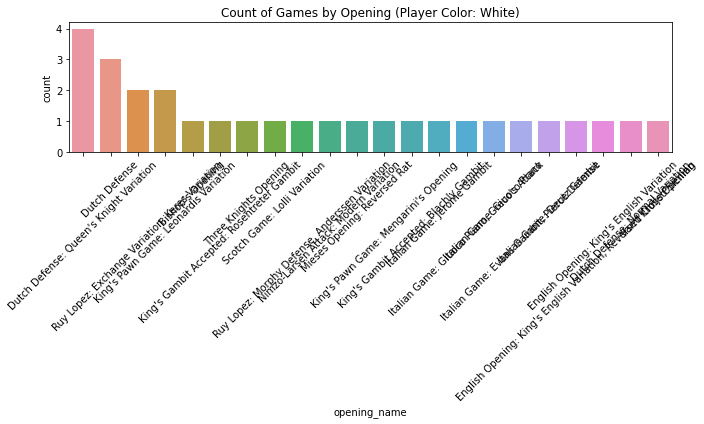

In [362]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the counts and sort by count for games59
opening_order = games59.groupby('opening_name').size().sort_values(ascending=False).index.tolist()

plt.figure(figsize=(10, 6))
sns.countplot(x='opening_name', data=games59, order=opening_order)
plt.title('Count of Games by Opening (Player Color: White)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
